# Arbitrage Sandbox

Here we generate a set of internal markets (using `curvesim` and `crvusdsim`) and external markets (using `src.modules.market.py`). We also generate stochastic external market prices for all tokens pertaining to these markets.

Our goal is to derive an algorithm that identifies the optimal set of trades to maximize profits as the external market price of each token changes.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src.modules.market import ExternalMarket
from src.modules.llamma import LLAMMA
from src.modules.oracle import Oracle
from src.sim.slippage import analyze

from curvesim.pool import get_sim_pool, SimCurvePool

# from crvusdsim.pool import get

In [9]:
WINDOW = 600  # 10 minutes
START = 1697675181  # Update with: datetime.now().timestamp()
TOKENS = ["USDT", "USDC", "USDP", "TUSD", "ETH", "BTC", "crvUSD"]

## Initialize pools

There are three kinds of pools:

1. StableSwap pools. These are Curve AMMs that we simulate using `curvesim`.
2. LLAMMAs. These are the AMMs that store collateral positions, like ETH/crvUSD. We are still deciding whether to simulate these using `crvusdsim`, a separate package for crvUSD (which is unstable and under development), or our own code in `src.modules`.
3. External markets. These are markets outside of Curve, and may be an AMM like Uniswap or a LOB like Binance. Since we have only analyzed the price impact on WETH/USDC on Uniswap, we will only create a single external market using the coefficients that we have observed. We can pretend that we have many external markets by feeding in different prices to the `trade` function.

In [ ]:
# StableSwap Pools
USDC_POOL = "0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E"  # USDC/crvUSD
USDT_POOL = "0x390f3595bca2df7d23783dfd126427cceb997bf4"  # USDT/crvUSD
USDP_POOL = "0xca978a0528116dda3cba9acd3e68bc6191ca53d0"  # USDP/crvUSD
TUSD_POOL = "0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0"  # TUSD/crvUSD

# Using curvesim
curve_pools = [
    get_sim_pool(address, balanced=False)
    for address in [USDC_POOL, USDT_POOL, USDP_POOL, TUSD_POOL]
]

In [ ]:
# LLAMMA Pools
# TODO need to import the relevant LLAMMA pools using crvusdsim
# but having trouble with some import errors

# ETH_POOL = 'eth'
# BTC_POOL = 'wbtc'

# llammas = [get(name) for name in [ETH_POOL, BTC_POOL]]

Mean percentage error: 0.004%
Mean percentage error: 0.006%


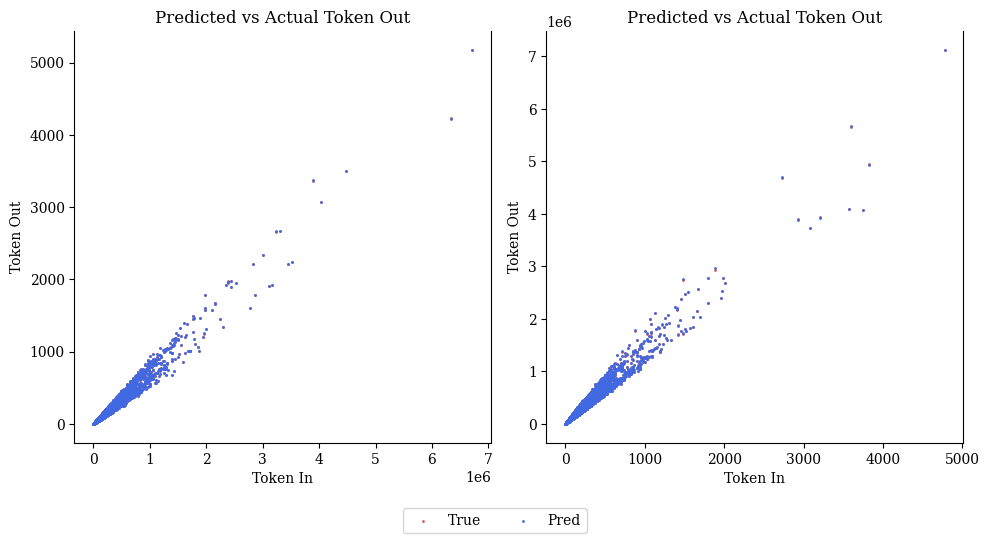

In [7]:
# External Pools
decimals = [18, 6]
coefs, intercepts, _ = analyze("../data/slippage/eth_usdc_0_3.csv", decimals, plot=True)
external_market = ExternalMarket(2, coefs, intercepts)

In [12]:
# Although we only created one external market, we can pretend that
# we have one external market for each permutation of tokens.
# For example

from itertools import combinations

list(combinations(TOKENS[:-1], 2))

[('USDT', 'USDC'),
 ('USDT', 'USDP'),
 ('USDT', 'TUSD'),
 ('USDT', 'ETH'),
 ('USDT', 'BTC'),
 ('USDC', 'USDP'),
 ('USDC', 'TUSD'),
 ('USDC', 'ETH'),
 ('USDC', 'BTC'),
 ('USDP', 'TUSD'),
 ('USDP', 'ETH'),
 ('USDP', 'BTC'),
 ('TUSD', 'ETH'),
 ('TUSD', 'BTC'),
 ('ETH', 'BTC')]

In [ ]:
# We can assume that all those external markets exist
# And we call external_market.trade(amt, price, i, j)
# based on the price if token i against token j

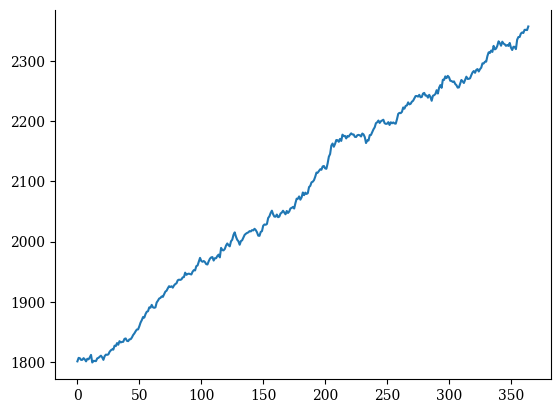

In [15]:
# We have a more sophisticated price generator and I'll sub it in here soon


def generate_gbm(S0, mu, sigma, T, dt):
    """
    Generate a Geometric Brownian Motion path.

    Parameters:
    S0 : float
        Initial stock price
    mu : float
        Expected return
    sigma : float
        Standard deviation of returns
    T : float
        Total time period
    dt : float
        Time step size

    Returns:
    numpy.ndarray
        Simulated GBM path
    """
    n = int(T / dt)
    t = np.linspace(0, T, n)
    W = np.random.standard_normal(size=n)
    W = np.cumsum(W) * np.sqrt(dt)  # the Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)  # the geometric brownian motion
    return S


prices = generate_gbm(1800, 0.001, 0.002, 365, 1)


plt.plot(prices)

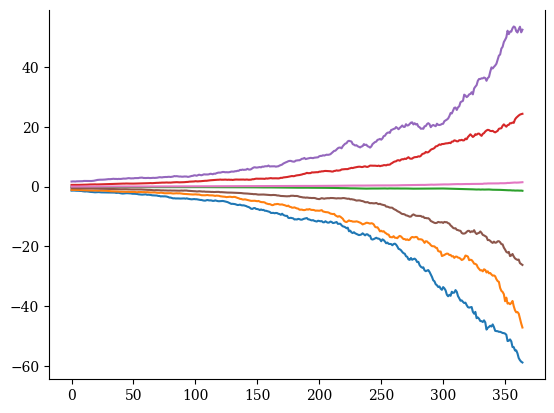

In [20]:
prices = []
for token in TOKENS:
    # Need to substitute this with realistic parameters
    s0 = np.random.randn(1)[0]
    mu = 0.01
    sigma = 0.02
    prices_i = generate_gbm(s0, mu, sigma, 365, 1)
    plt.plot(prices_i)
    prices.append(prices_i)

In [23]:
# So now prices[i] is the USD price of token i, and prices[i]/prices[j] gives us the i/j exchange rate

"""
TODO for Thomas
1. Replace prices with reasonable params
2. Fix crvusdsim so that we can use it here
3. Perform price impact analysis on other markets instead of just using WETH/USDC for all of them
4. Think of which other markets we should include (there are some other relevant Curve pools, for example)
"""
pass